In [6]:
# TODO: https://stackoverflow.com/questions/51520189/zero-occurrences-frequency-using-value-counts-in-pandas

# Plotting

from typing import Tuple
import pandas as pd
from pandas.testing import assert_series_equal
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from seaborn import FacetGrid
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.container import BarContainer
from matplotlib.patheffects import withStroke

sns.set_style('whitegrid')
sns.set_palette(reversed(sns.color_palette("Blues", 6)), 6)
mpl.rcParams['figure.dpi'] = 144
mpl.rcParams['font.family'] = 'Hiragino Sans'
mpl.rcParams["patch.force_edgecolor"] = False

percent_locator = ticker.MaxNLocator(10, steps=[1, 2, 2.5, 5, 10])

def adjust_figure_for_v(figure: Figure, n: int | None, title: str, description: str = '', percent: bool = True):
    ax = figure.axes[0]
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.xaxis.grid(False)
    if percent:
        ax.yaxis.set_major_formatter(ticker.PercentFormatter())
        ax.yaxis.set_major_locator(percent_locator)
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', padding=4)
        ax.set_ylim(ymin=0, ymax=101, auto=None) # 101 for prevent tick label from being clipped by frame.
    figure.suptitle(title)
    figure.subplots_adjust(top=0.9, right=0.9)
    if n is not None:
        figure.text(0.98, 0.12, f"N={n}", ha='right')
    if description:
        figure.text(0.03, -0.02, description, ha='left', va='top')    

def adjust_figure_for_h(figure: Figure, n: int | None, title: str, description: str = '', percent: bool = True, bar_label: bool = True):
    ax = figure.axes[0]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.yaxis.grid(False)
    if percent:
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_major_locator(percent_locator)
        if bar_label:
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', padding=4)
        ax.set_xlim(xmin=0, xmax=101, auto=None) # 101 for prevent tick label from being clipped by frame.
    figure.suptitle(title)
    figure.subplots_adjust(top=0.9, right=0.9)
    if n is not None:
        figure.text(0.98, 0.12, f"N={n}", ha='right')
    if description:
        figure.text(0.03, -0.02, description, ha='left', va='top')    

def adjust_figure_for_h_stack(figure: Figure, n: int | None, title: str, description: str = ''):
    adjust_figure_for_h(figure, n, title, description, percent=True, bar_label=False)

    class ReversePercentFormatter(ticker.PercentFormatter):
        def format_pct(self, x, display_range) -> str:
            return super().format_pct(100 - x, display_range)
    ax = figure.axes[0]
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.invert_xaxis()
    ax.set_xlim(xmin=100, xmax=-3, auto=None) # -1 for prevent tick label from being clipped by frame.
    ax.xaxis.set_major_formatter(ReversePercentFormatter())
    container: BarContainer
    for i, container in enumerate(reversed(ax.containers)):
        if i >= 2:
            color='#000'
        else:
            color='#fff'
        path_effects = None
        if len(ax.containers) >= 2:
            path_effects=[withStroke(linewidth=2.5, foreground=f'C{i}')]
        ax.bar_label(container, fmt='%.1f%%', padding=4, label_type='center', fontsize=8, fontweight='bold', color=color, path_effects=path_effects)
    figure.subplots_adjust(top=0.88)
    sns.move_legend(figure, 'upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, title='')


# 縦棒
def vbar(data_series: pd.Series, n: int | None, title: str, description: str = '', percent: bool = True):
    grid: FacetGrid = sns.catplot(data=data_series.to_frame().transpose(), kind='bar', orient='v', width=0.5, height=5, aspect=16/9, color="C0")
    figure: Figure = grid.figure
    adjust_figure_for_v(figure, n, title, description, percent)
    return figure

# 横棒
def hbar(data_series: pd.Series, n: int | None, title: str, description: str = '', percent: bool = True):
    grid: FacetGrid = sns.catplot(data=data_series.to_frame().transpose(), kind='bar', orient='h', width=0.5, height=5, aspect=16/9, color="C0")
    figure: Figure = grid.figure
    adjust_figure_for_h(figure, n, title, description, percent)
    return figure


In [7]:
questions = pd.read_csv('./config/questions.csv', index_col=0).squeeze()

# Setup choices_df
# choices_df contains multiple candidates of choice indexed by column name
choices_df = pd.read_csv('./config/choices.csv')
col_names = questions.index.to_series()
assert_series_equal(choices_df['設問文章'], questions[questions != "タイムスタンプ"], check_names=False, check_index=False)
choices_df.index = col_names.drop(index=questions[questions == "タイムスタンプ"].index).values
choices_df['選択肢'] = choices_df['選択肢'].str.split(',')
choices_df['選択肢'].where(choices_df['選択肢'].notna(), None, inplace=True)

# NOTE: list() will be loaded as np.array()
df = pd.read_feather('out/after_coded.feather')
df.set_index('回答番号', inplace=True)
for col in choices_df[choices_df['複数回答'] == 1].index:
    df[col] = df[col].map(lambda x: x.tolist())

label_q_ids = ['Y', 'AN', 'AS']
label_map = {
    'アセクシュアル': 'アセク',
    'アロマンティック': 'アロマ',
    'セクシュアル【性的に惹(ひ)かれる】': 'セク',
    'ロマンティック【恋愛的に惹(ひ)かれる】': 'ロマ',
    'デミセクシュアル': 'デミセク',
    'デミロマンティック': 'デミロマ',
    'グレイアセクシュアル/グレイセクシュアル': 'グレイセク',
    'グレイアロマンティック/グレイロマンティック': 'グレイロマ',
    'リスセクシュアル': 'リスセク',
    'リスロマンティック': 'リスロマ',
    'クエスチョニング': 'Q',
}

df[label_q_ids] = df[label_q_ids].replace(label_map)

exploded_choices_df = choices_df.loc[label_q_ids, '選択肢'].explode()
updated_exploded_choices_df = exploded_choices_df.replace(label_map).groupby(exploded_choices_df.index).agg(list)
choices_df.update(updated_exploded_choices_df)


In [8]:
# 棒
from typing import List


def plot_bar(column: str, direction: str, title: str, description: str = '', other_groups: List[str] = [], sort: bool = False):
    values = df[column].dropna()
    if choices_df.loc[column, '複数回答'] == 1:
        values = values[df[column].astype(bool)]  # drop empty list
    n = len(values)

    grouped = values.explode().value_counts(sort=sort) * 100 / n

    choices = grouped.index if sort else pd.Index(choices_df.loc[column, '選択肢']).union(grouped.index, sort=False)
    index_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups))

    grouped = grouped.reindex(index_order)

    if direction == 'v':
        vbar(grouped, n, title, description)
    elif direction == 'h':
        hbar(grouped, n, title, description)

def plot_age_bin_bar(column: str, direction: str , title: str, description: str = ''):
    ages = df[column].dropna()
    n = len(ages)

    ages_bin = pd.cut(ages, [-1, 20, 25, 30, 35, 40, 45, 10000], labels=['20歳未満', '20-24歳', '25-29歳', '30-34歳', '35-39歳', '40-44歳', '45歳以上'], right=False)

    ages_bin_count = ages_bin.value_counts(sort=False) * 100 / n

    if direction == 'v':
        vbar(ages_bin_count, n, title, description)
    elif direction == 'h':
        hbar(ages_bin_count, n, title, description)

def plot_staked_hbar(column: str, title: str, description: str = '', other_groups: List[str] = []):
    counts = (df[column]
            .value_counts(normalize=True)
            .mul(100)
            .rename_axis(column)
            .rename('percent')
            .to_frame())
    n = df[column].count()

    choices = pd.Index(choices_df.loc[column, '選択肢']).union(counts.index, sort=False)
    index_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups)).rename(column)

    counts = counts.reindex(index_order)

    grid: FacetGrid = sns.displot(
        data=counts, y=[''] * len(counts), hue=column, weights='percent',
        multiple='stack', shrink=0.8, discrete=True,
        alpha=1,
        hue_order=choices_df.loc[column, '選択肢'],
        aspect=16/9,
    )
    figure: Figure = grid.figure
    adjust_figure_for_h_stack(grid.figure, n, title, description)
    figure.axes[0].margins(y=0.7)

def plot_staked_hbar_grouped(column: str, group_by: str, title: str, description: str = '', other_groups: List[str] = []):
    table = pd.crosstab(df[column], df[group_by], normalize='columns')

    choices = pd.Index(choices_df.loc[group_by, '選択肢']).union(pd.Index(table.columns), sort=False)
    col_order = choices.drop(other_groups, errors='ignore').append(pd.Index(other_groups))

    counts = table.filter(col_order).unstack(fill_value=0).mul(100).rename('percent').reset_index()
    n = len(counts)

    grid: FacetGrid = sns.displot(
        data=counts, y=group_by, hue=column, weights='percent',
        multiple='stack', shrink=0.8, discrete=True,
        alpha=1,
        hue_order=choices_df.loc[column, '選択肢'],
        aspect=16/9,
    )
    figure: Figure = grid.figure
    adjust_figure_for_h_stack(grid.figure, None, title, description)


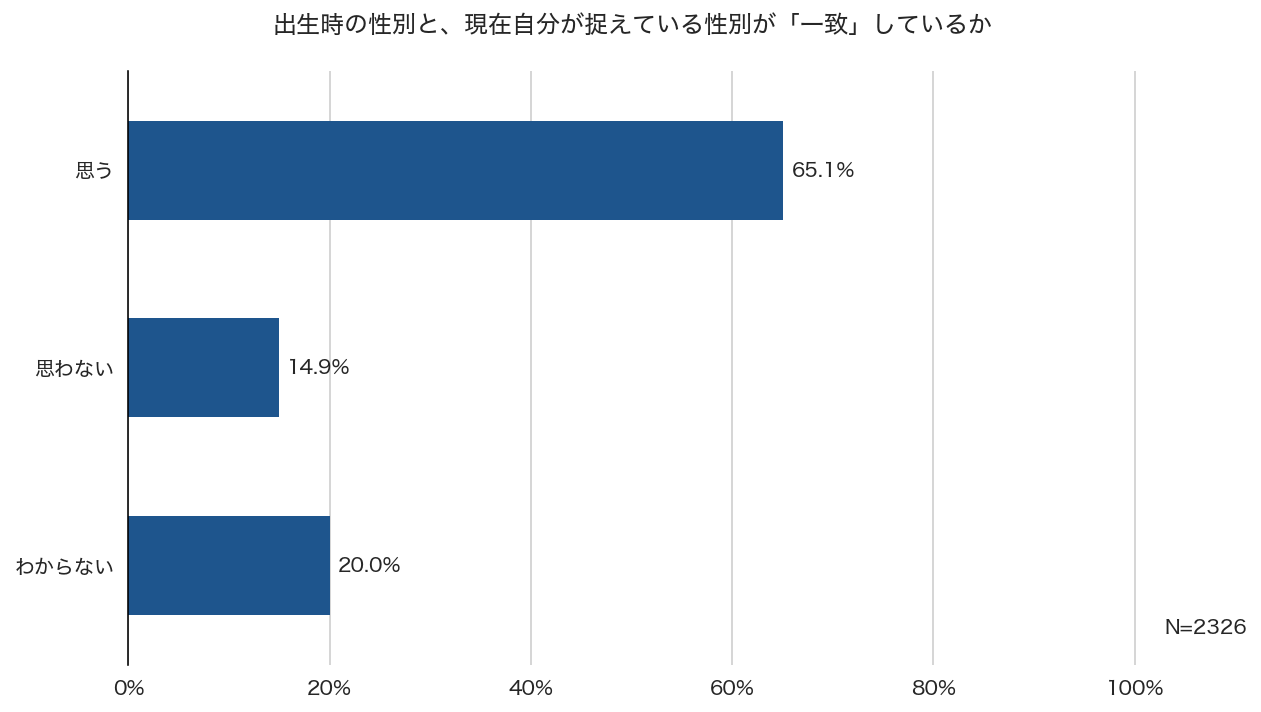

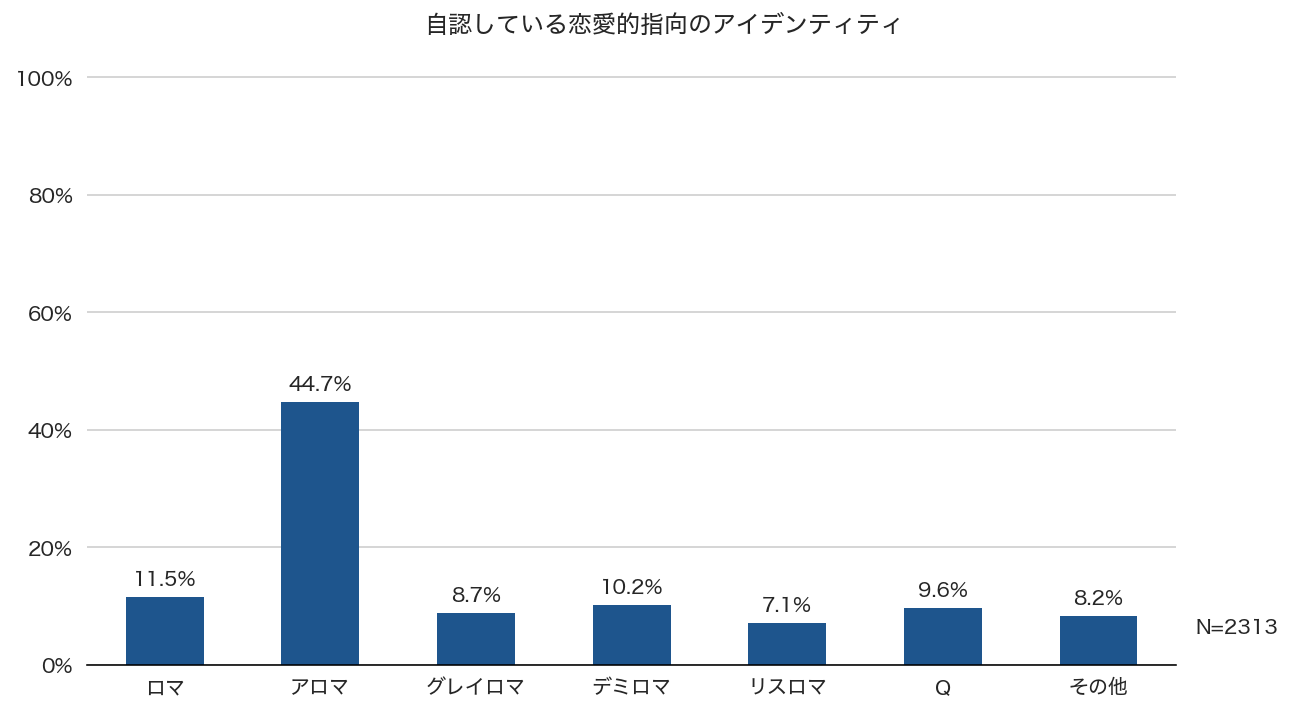

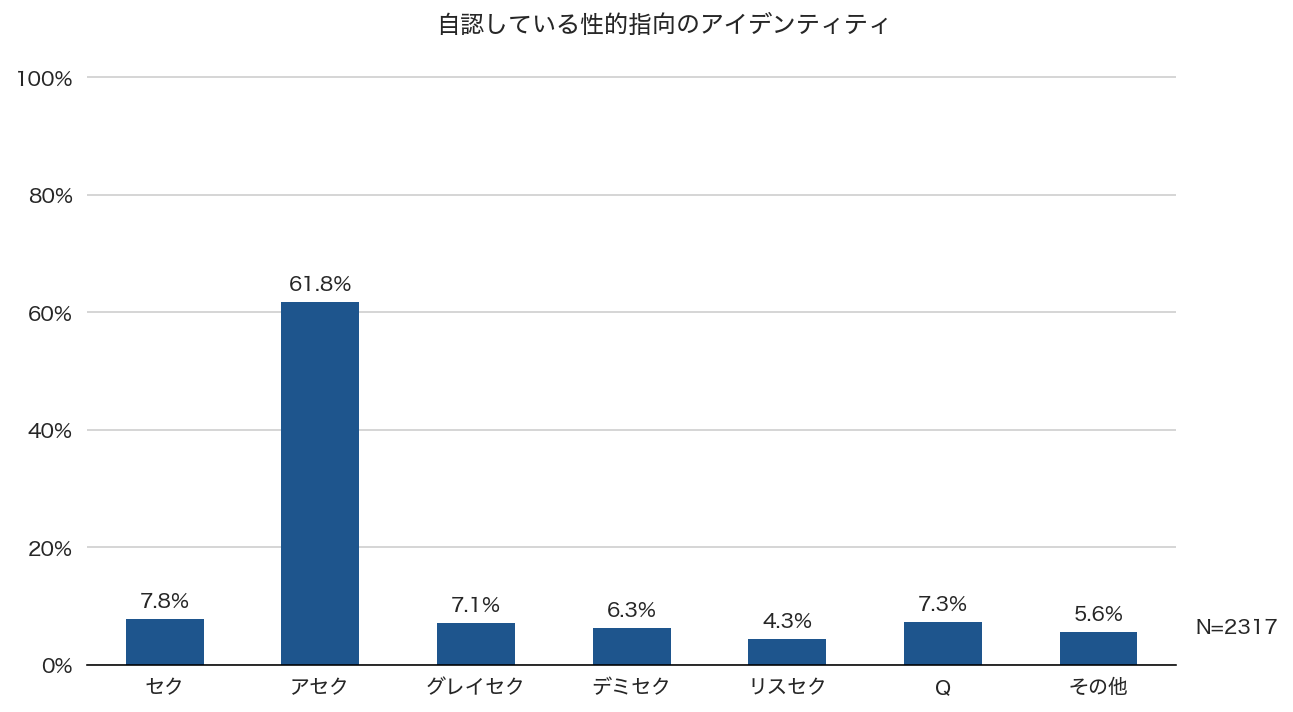

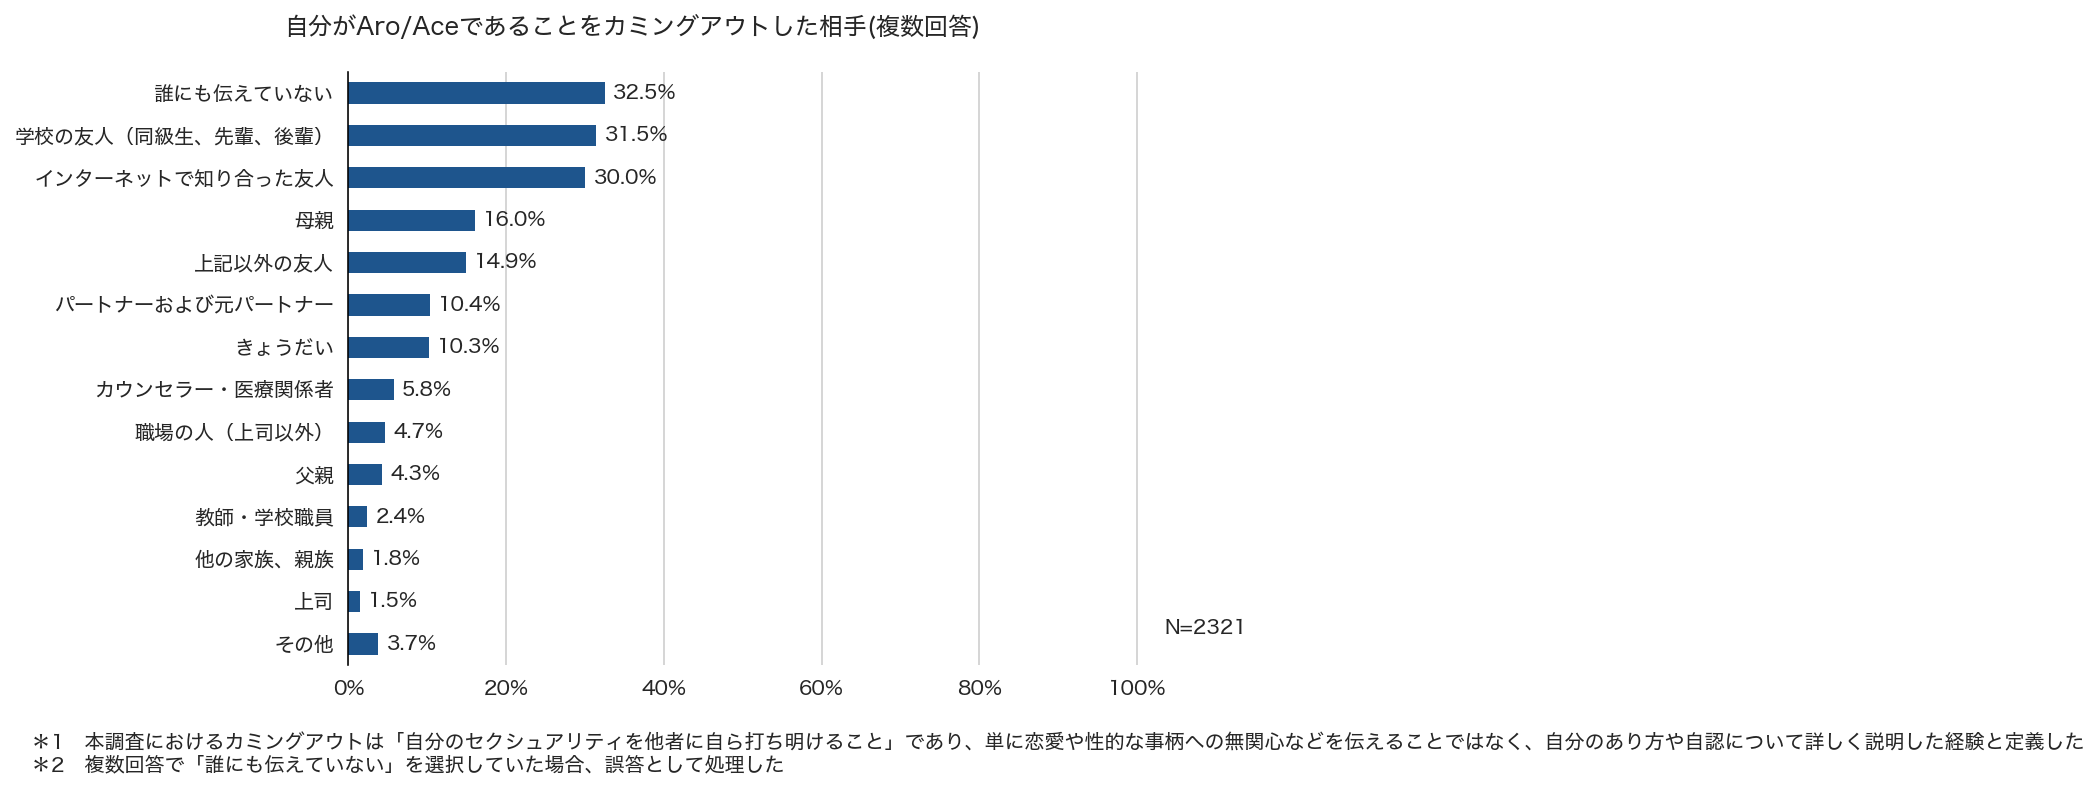

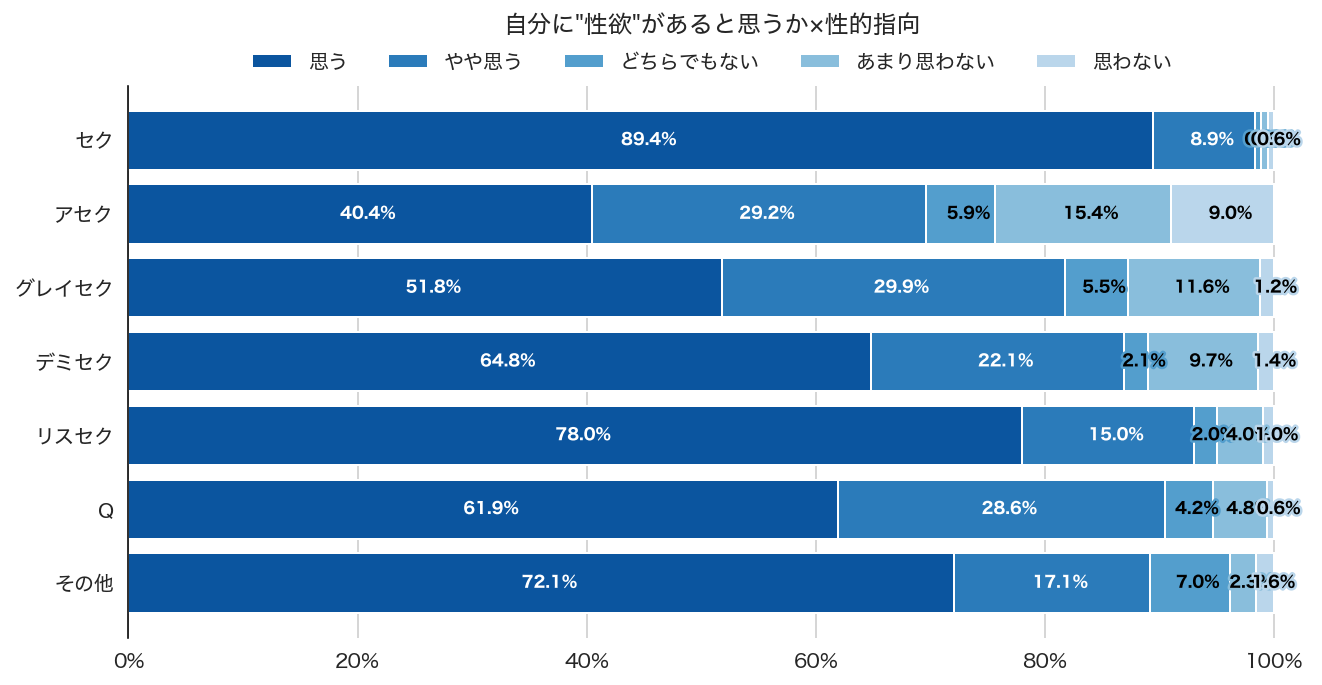

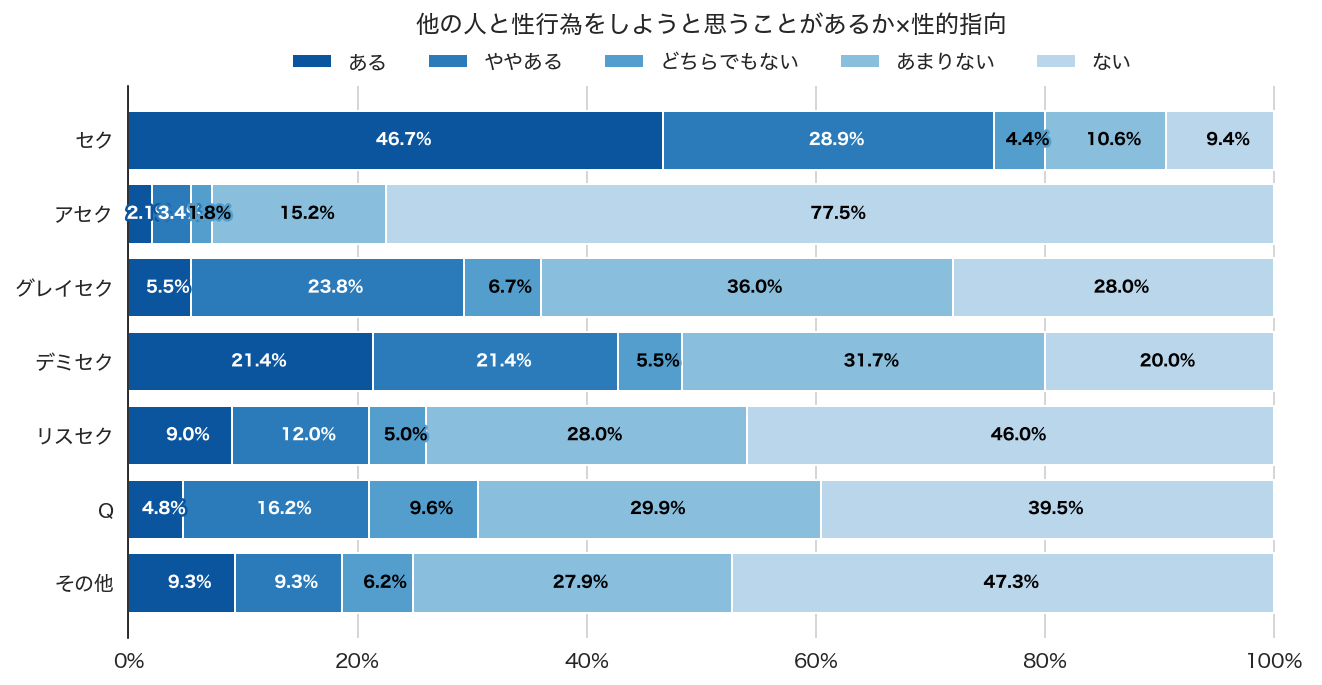

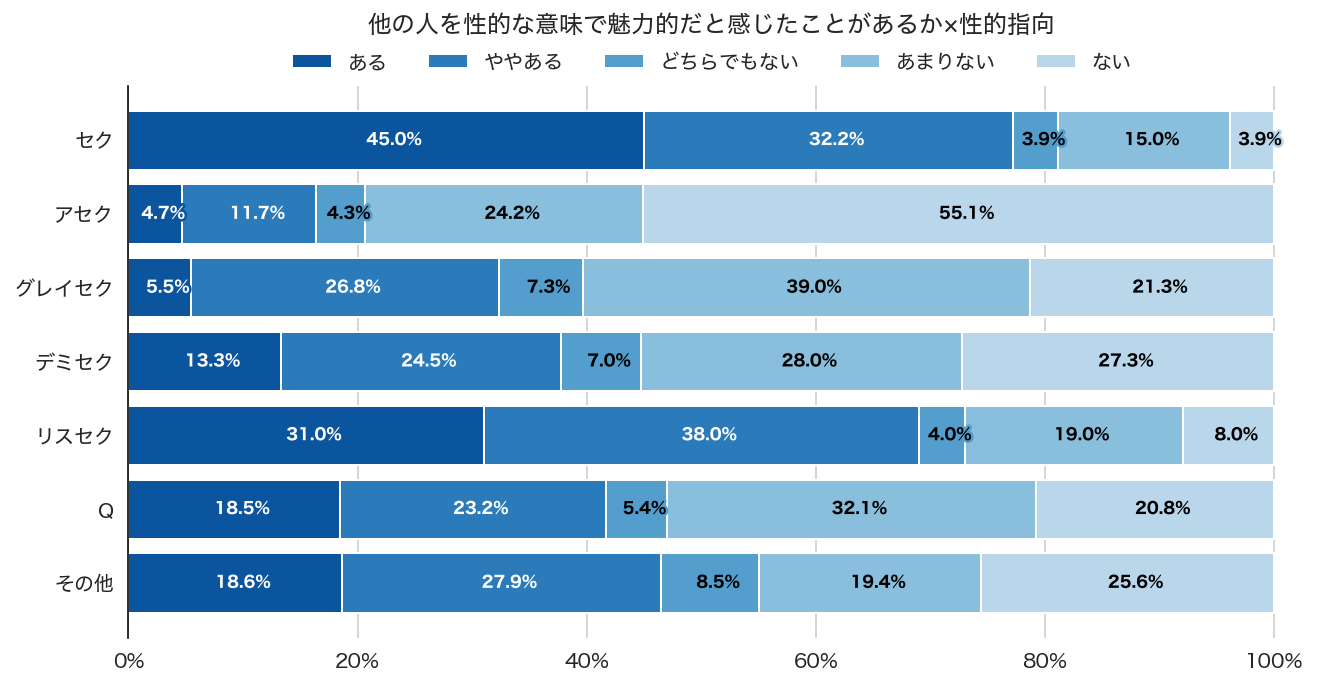

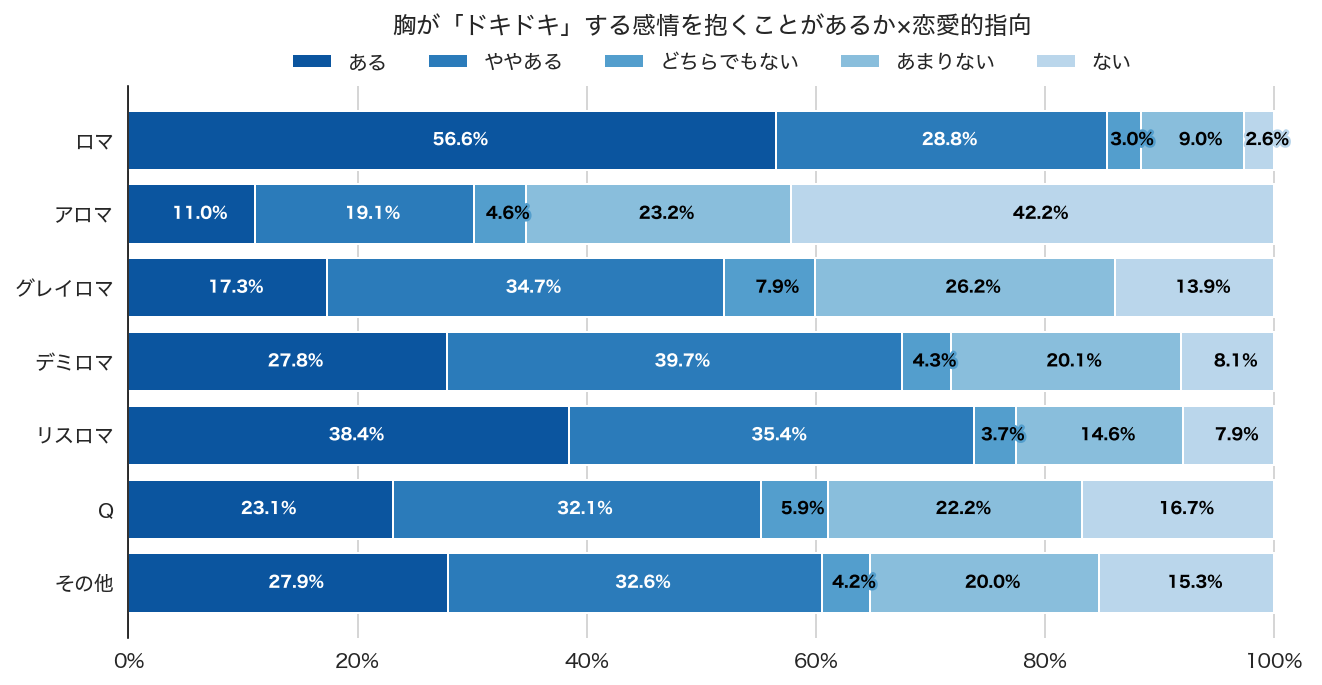

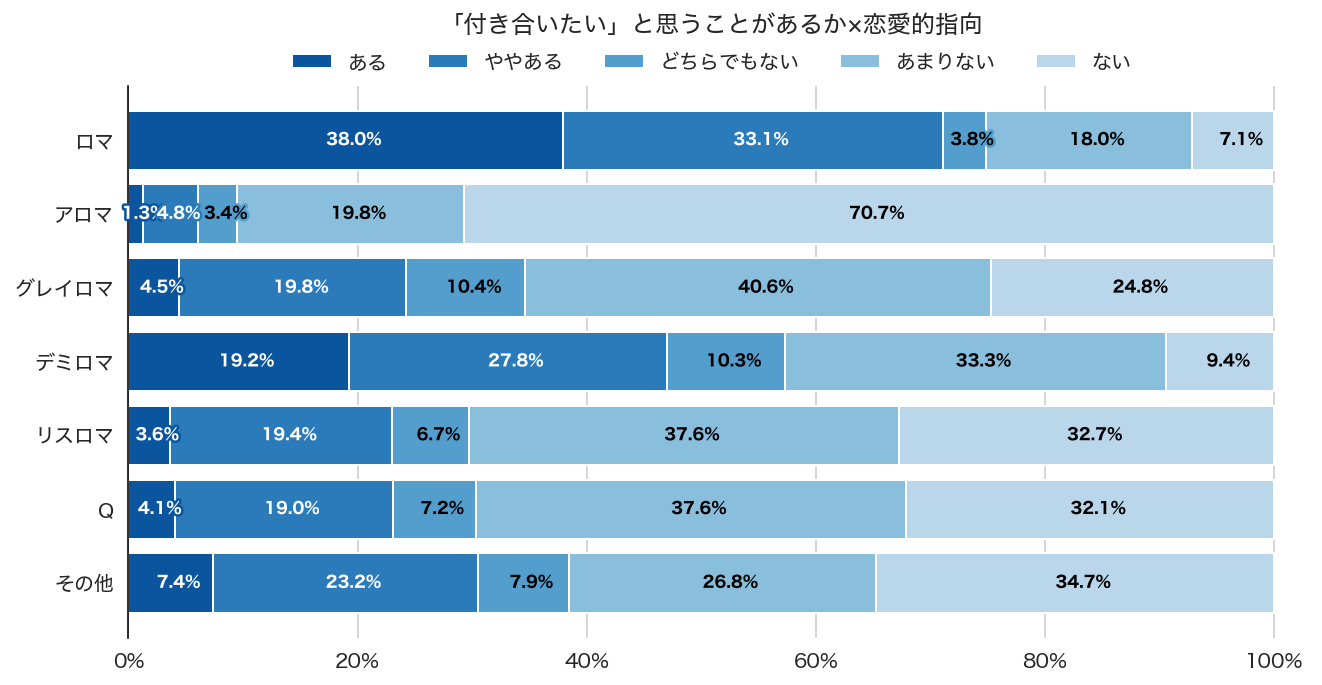

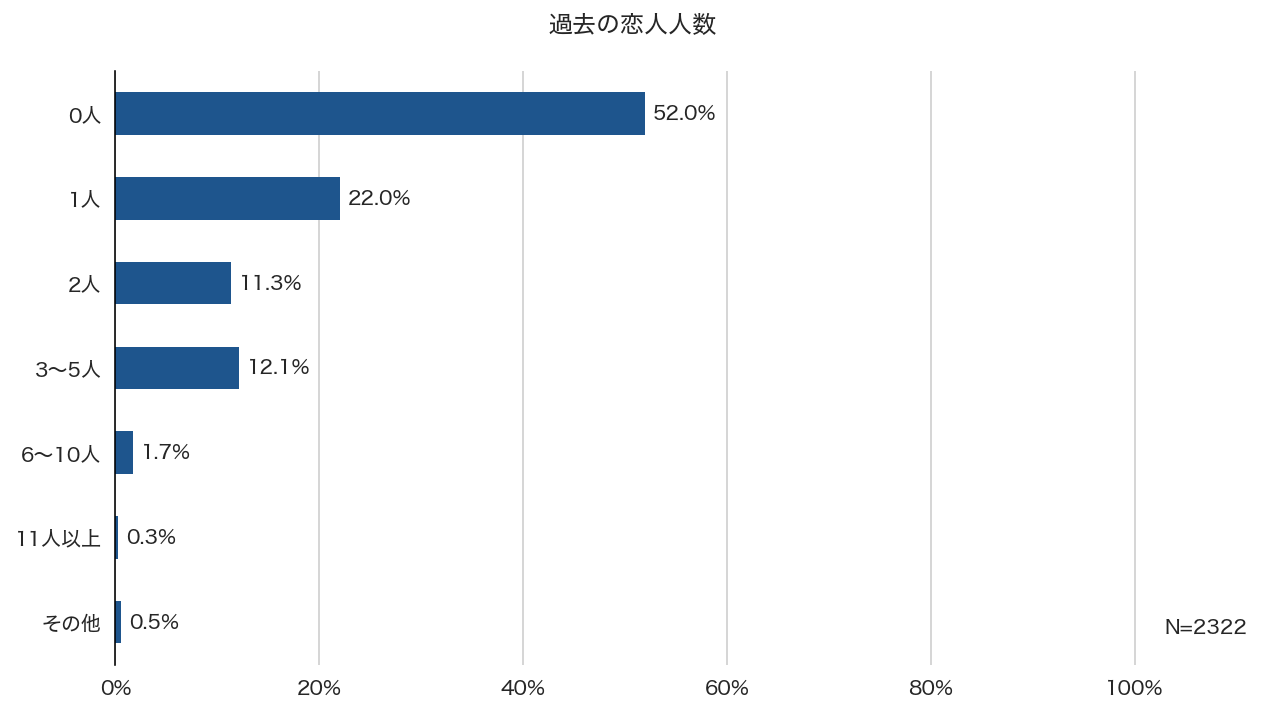

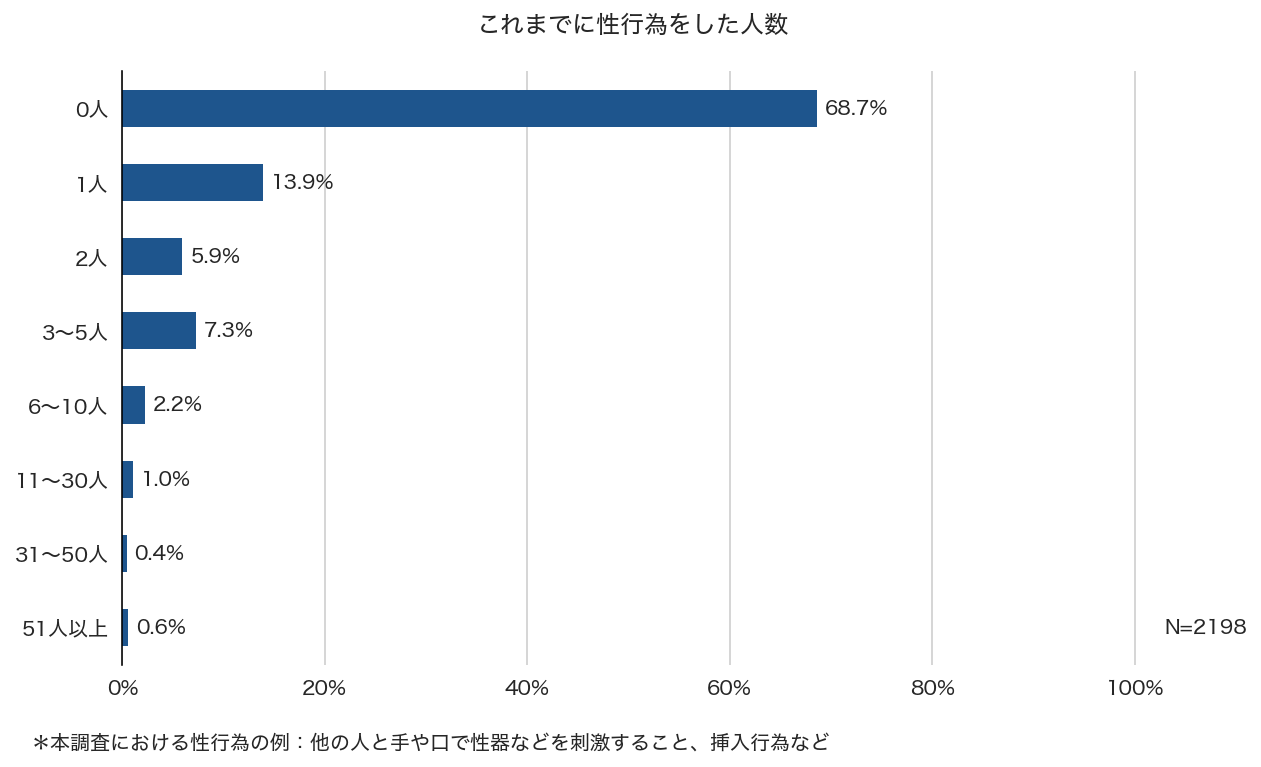

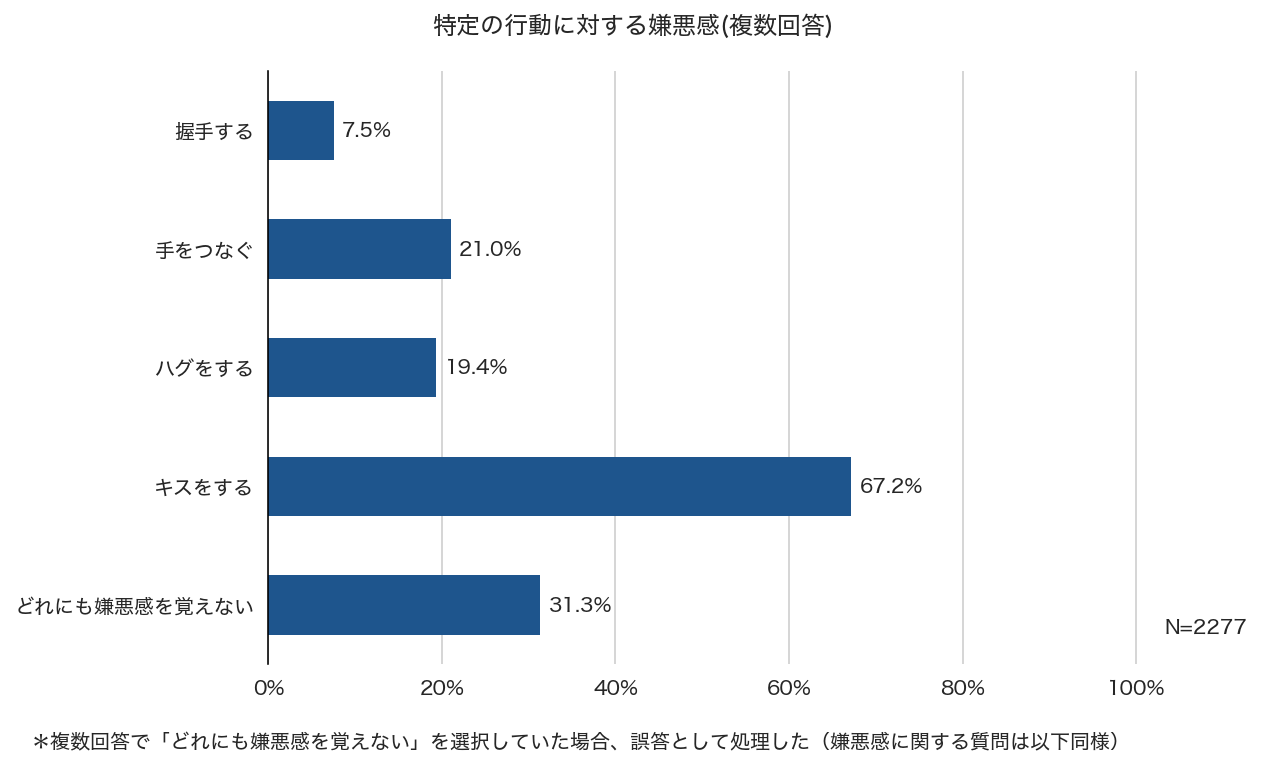

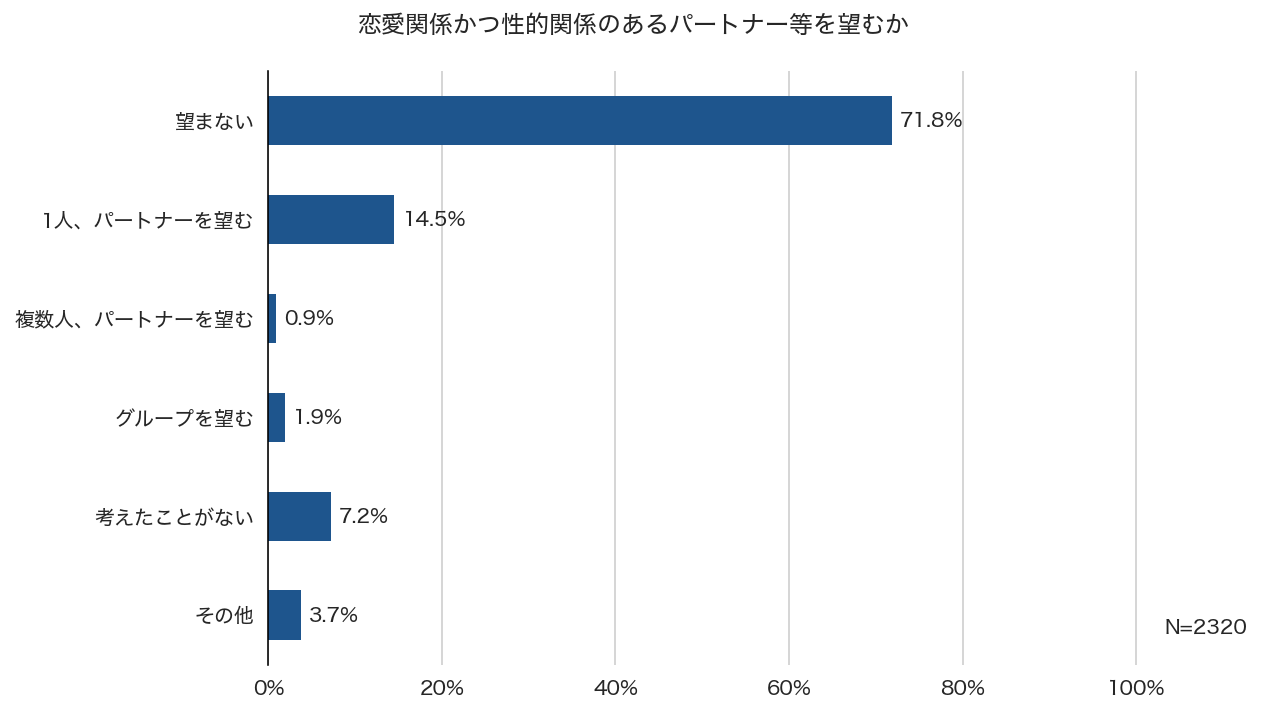

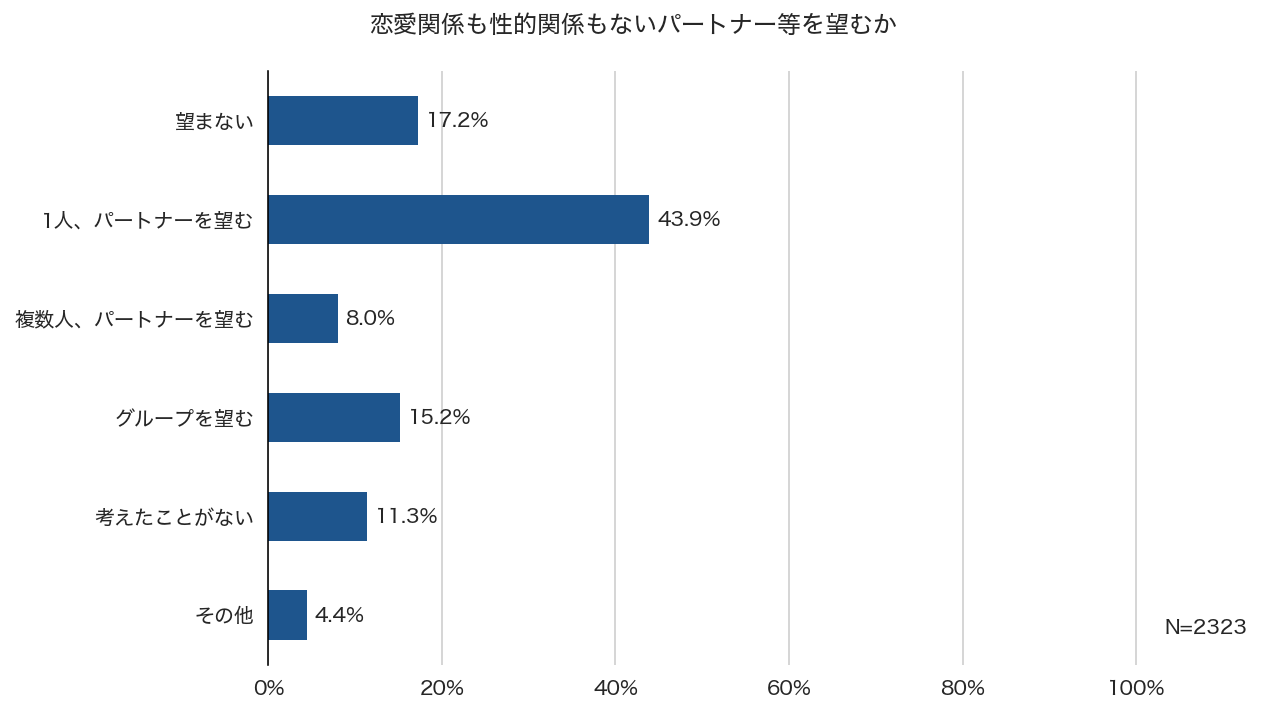

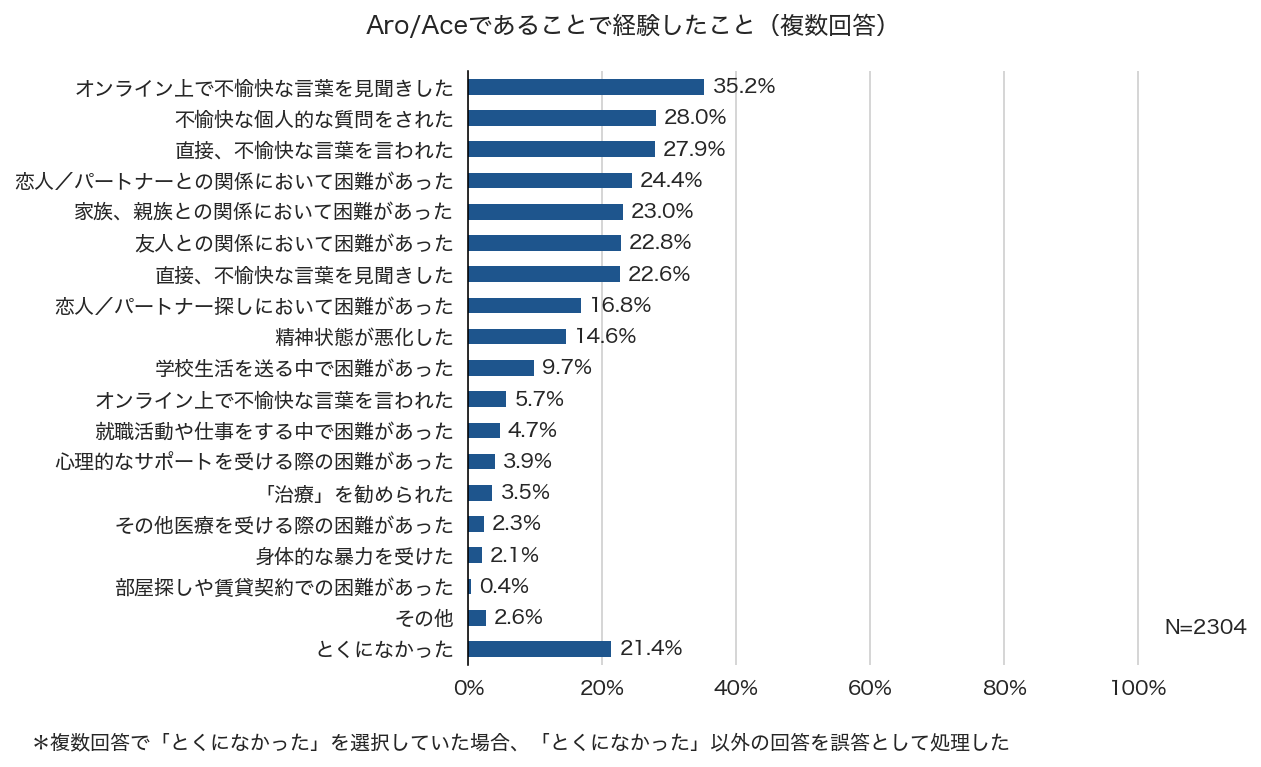

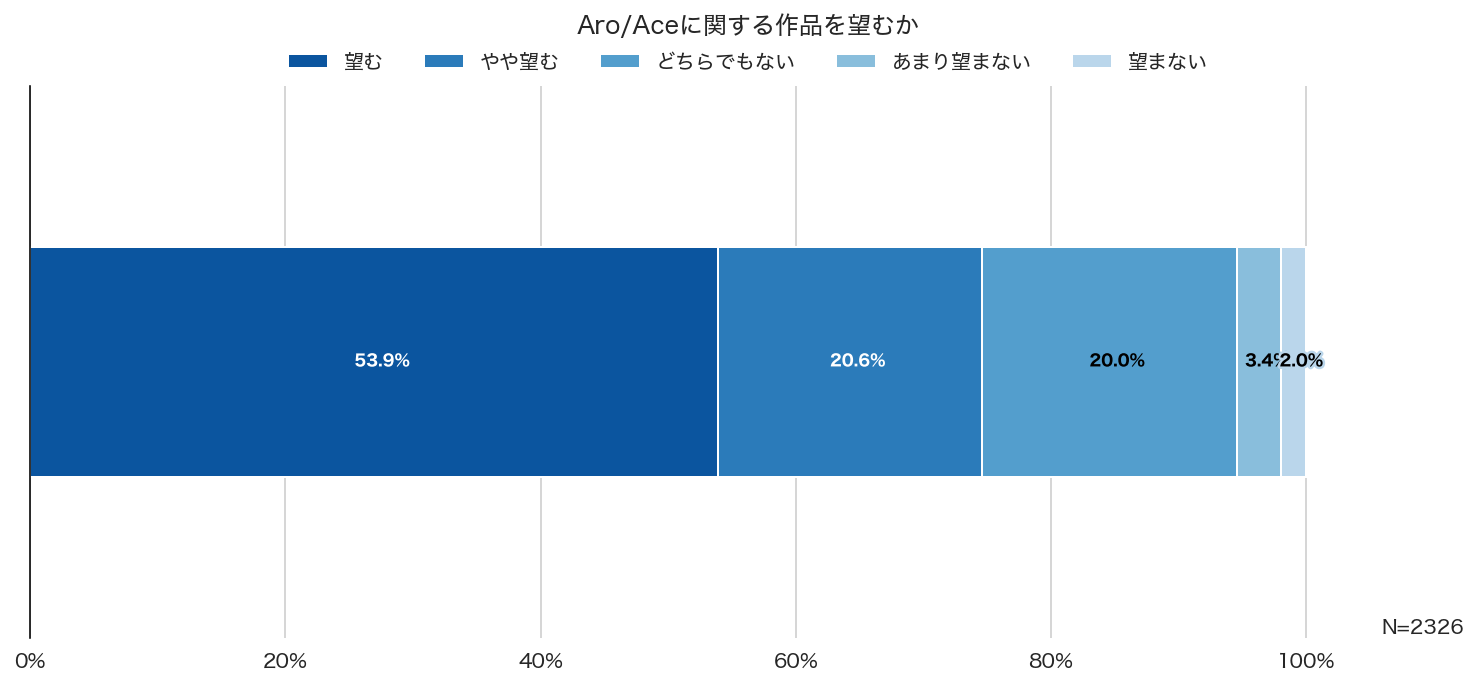

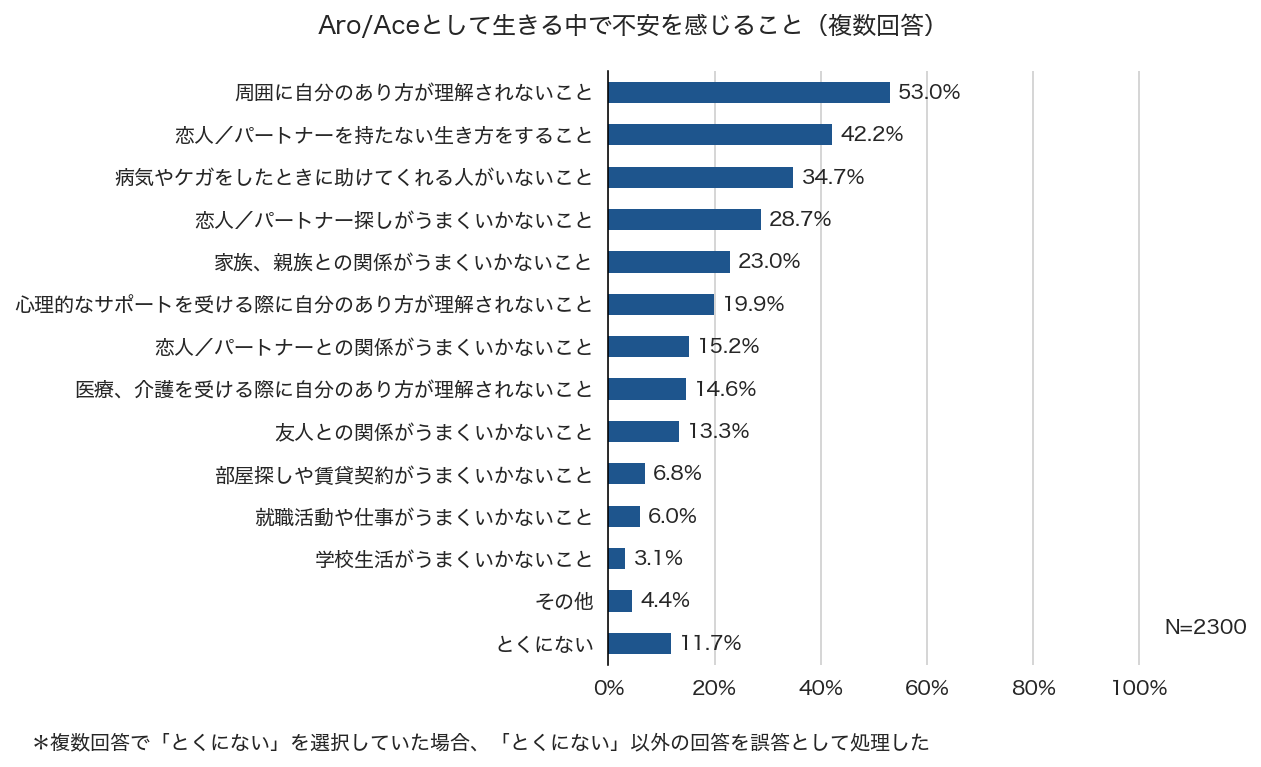

In [11]:
# 描画

plot_bar('M', 'h', '出生時の性別と、現在自分が捉えている性別が「一致」しているか')
# "左：「一致」している人の男女比(Aro/Ace調査)
# 右：国勢調査の男女比"	N		横積み上げ		国勢調査との比較
# 年齢	D		縦棒		スライド2枚：①国勢調査との比較、②前年度と比較、
# 居住地	E		縦棒		国勢調査との比較		日本以外
plot_bar('Y', 'v', '自認している恋愛的指向のアイデンティティ')
plot_bar('AN', 'v', '自認している性的指向のアイデンティティ')
# 主な恋愛的指向×性的指向アイデンティティの組み合わせ	Y	AN	表	＊組み合わせの中から任意で抜粋しているため、回答数による降順ではない	IDの組み合わせ、前年度と比較→縦軸にセクシュアリティの組み合わせ、横軸に2020・2022を入れて1枚の大きな表にしてほしいです（右の青い部分を見て）

plot_bar('AZ', 'h', '自分がAro/Aceであることをカミングアウトした相手(複数回答)',
    '＊1　本調査におけるカミングアウトは「自分のセクシュアリティを他者に自ら打ち明けること」であり、単に恋愛や性的な事柄への無関心などを伝えることではなく、自分のあり方や自認について詳しく説明した経験と定義した\n＊2　複数回答で「誰にも伝えていない」を選択していた場合、誤答として処理した',
    other_groups=['その他'],
    sort=True)

plot_staked_hbar_grouped('AF', 'AN', '自分に"性欲"があると思うか×性的指向')
plot_staked_hbar_grouped('AE', 'AN', '他の人と性行為をしようと思うことがあるか×性的指向')
plot_staked_hbar_grouped('AH', 'AN', '他の人を性的な意味で魅力的だと感じたことがあるか×性的指向')

plot_staked_hbar_grouped('S', 'Y', '胸が「ドキドキ」する感情を抱くことがあるか×恋愛的指向')
plot_staked_hbar_grouped('Q', 'Y', '「付き合いたい」と思うことがあるか×恋愛的指向')

plot_bar('BB', 'h', '過去の恋人人数')
plot_bar('CX', 'h', 'これまでに性行為をした人数', '＊本調査における性⾏為の例：他の⼈と⼿や⼝で性器などを刺激すること、挿⼊⾏為など')

plot_bar('CH', 'h', '特定の行動に対する嫌悪感(複数回答)', '＊複数回答で「どれにも嫌悪感を覚えない」を選択していた場合、誤答として処理した（嫌悪感に関する質問は以下同様）', ['どれにも嫌悪感を覚えない'])

# 恋愛要素のあることに対する嫌悪感×恋愛的指向	CF	Y	縦棒	＊質問紙には上記以外に「異性間の恋愛作品の鑑賞」、「男性同士の恋愛作品の鑑賞」、「女性同士の恋愛作品の鑑賞」という選択肢があり、「どれにも嫌悪感を覚えない」はそれらを含め覚えないと回答したものである	一部設問のみ表示：「他の人の恋愛話を聞く」、「自分の恋愛話を聞かれる」、「どれにも嫌悪感を覚えない」		どれにも嫌悪感を覚えない
plot_bar('BK', 'h', '恋愛関係かつ性的関係のあるパートナー等を望むか')
plot_bar('BM', 'h', '恋愛関係も性的関係もないパートナー等を望むか')
plot_bar('CO', 'h', 'Aro/Aceであることで経験したこと（複数回答）', '＊複数回答で「とくになかった」を選択していた場合、「とくになかった」以外の回答を誤答として処理した', other_groups=['その他', 'とくになかった'], sort=True)

plot_staked_hbar('CC', 'Aro/Aceに関する作品を望むか')

# plot_bar_grouped('AB', 'Y', '自認（性的指向）をためらったことがあるか×性的指向')
# plot_bar_grouped('AP', 'AN', '自認（恋愛的指向）をためらったことがあるか×恋愛的指向')

plot_bar('CQ', 'h', 'Aro/Aceとして生きる中で不安を感じること（複数回答）', '＊複数回答で「とくにない」を選択していた場合、「とくにない」以外の回答を誤答として処理した', other_groups=['その他', 'とくにない'], sort=True)


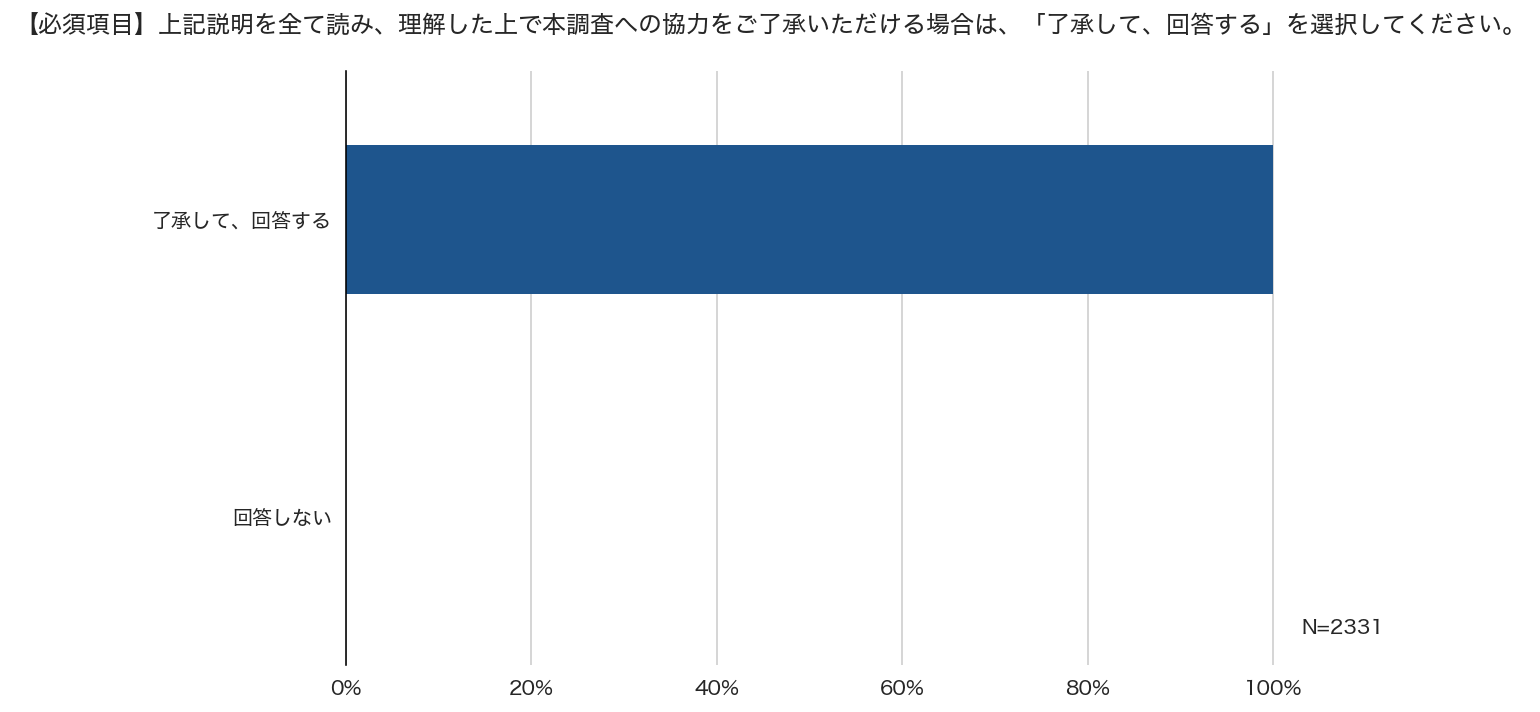

In [19]:
#　単純集計をすべてグラフに起こす

import os

os.makedirs('out/images', 0o755, exist_ok=True)

# for column in df:
for column in ['B']:
    if column == 'A':
        # Skip timestamp column
        continue

    values = df[column].dropna()
    if choices_df.loc[column, '複数回答'] == 1:
        values = values[df[column].astype(bool)]  # drop empty list
    n = len(values)

    grouped = values.explode().value_counts() * 100 / n
    if len(grouped) > 50:
        print(f"column {column} has too many variations ({len(grouped)})")
        continue
    if len(grouped) == 0:
        print(f"column {column} is empty")
        continue

    if grouped.index.dtype.kind in ['i', 'u', 'f', 'c', 'm']:
        grouped.sort_index(inplace=True)
    else:
        choice_list = choices_df.loc[column, '選択肢']
        if choice_list:
            choice_series = pd.Series(choice_list)
            if not choice_series.str.isnumeric().all():
                grouped = grouped.reindex(pd.concat([choice_series, grouped.index.to_series()]).unique(), fill_value=0)
    figure = hbar(grouped, n, questions.loc[column])
    figure.savefig(f"out/images/figure-{column.rjust(2, '_')}.png", format="png", dpi=144)
